In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/AutoEncoder")

In [2]:
# imports
from keras.datasets import mnist
from keras.layers import Conv2D, Flatten, Dense, Reshape
from keras.layers import Conv2DTranspose, Input
from keras.models import Model
import keras.backend as K
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
"""Dynamic and Hyper parameters"""
image_shape = (28, 28, 1)
latent_dim = 16

filters = [32, 64]
stride = 2
kernel_size = 3
padding = "same"
activation = "relu"
initializer = "he_normal"

batch_size = 64
epochs = 5

In [5]:
"""Load and preprocess dataset"""
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape((-1, *image_shape)).astype("float32") / 255
x_test = x_test.reshape((-1, *image_shape)).astype("float32") / 255

11493376/11490434 [==============================] - 2s 0us/step


In [6]:
"""Encoder configurations"""
def build_encoder(inputs):

    x = inputs
    for filter in filters:
        x = Conv2D(filters=filter,
                   kernel_size=kernel_size,
                   strides=stride,
                   padding=padding,
                   activation=activation,
                   kernel_initializer=initializer)(x)
    conv_shape = K.int_shape(x)
    x = Flatten()(x)
    outputs = Dense(units = latent_dim)(x)

    model = Model(inputs, outputs, name = "Encoder")
    model.summary()
    return model, conv_shape

In [7]:
"""Decoder configurations"""
def build_decoder(inputs, denseShape):

    x = inputs
    x = Dense(denseShape[1] * denseShape[2] * denseShape[3])(x)
    x = Reshape(denseShape[1:])(x)
    for filter in filters[::-1]:
        x = Conv2DTranspose(filters=filter,
                   kernel_size=kernel_size,
                   strides=stride,
                   padding=padding,
                   activation=activation,
                   kernel_initializer=initializer)(x)
    outputs = Conv2DTranspose(filters=1,
                        kernel_size=1,
                        padding=padding,
                        strides=1,
                        activation="sigmoid")(x)
    model = Model(inputs, outputs, name = "Decoder")
    model.summary()
    return model

In [15]:
"""Plot"""
def plot(autoEnc):

    decoded_imgs = autoEnc.predict(x_test)
    imgs = np.concatenate([x_test[:8], decoded_imgs[:8]])
    imgs = imgs.reshape((4, 4, 28, 28))
    imgs = np.vstack([np.hstack(img) for img in imgs]) #????
    print(imgs.shape)
    plt.figure()
    plt.title('Input')
    plt.axis("off")
    plt.imshow(imgs[:56], interpolation = "None", cmap = "gray")
    plt.savefig('input.png')
    plt.figure()
    plt.title('Decoded')
    plt.axis("off")
    plt.imshow(imgs[56:], interpolation = "None", cmap = "gray")
    plt.savefig('decoded.png')
    plt.show()


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Sh

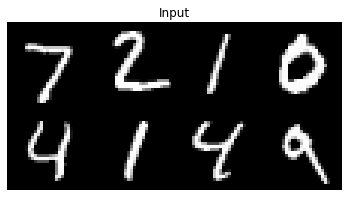

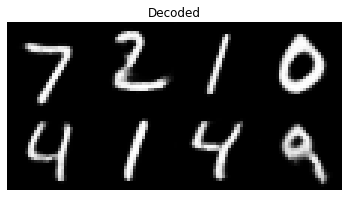

In [16]:
enc_inputs = Input(shape = image_shape)
enc, denseShape = build_encoder(enc_inputs)

dec_inputs = Input(shape = (latent_dim,))
dec = build_decoder(dec_inputs, denseShape)

autoEnc_inputs = enc_inputs
autoEnc_outputs = dec(enc(autoEnc_inputs))
autoEnc = Model(autoEnc_inputs, autoEnc_outputs, name = "Auto Encoder")
autoEnc.summary()
autoEnc.compile(loss = "mse", optimizer = "adam")
autoEnc.fit(x_train,
            x_train,
            batch_size = batch_size,
            epochs=epochs,
            validation_data = [x_test, x_test])
plot(autoEnc)